In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Read the csv file
df = pd.read_csv('/content/Extract.xlsx - Sheet1.csv')
print(df.head()) #7 columns, including the Date. 

   y       x1       x2       x3       x4
0  0  3861.22  3861.66  3860.75  3861.38
1  0  3861.19  3861.38  3860.16  3861.25
2  0  3861.38  3861.38  3858.47  3858.53
3  1  3858.72  3858.72  3857.03  3858.19
4  1  3858.09  3859.16  3858.03  3858.81


In [3]:
df.shape

(10000, 5)

In [4]:
#Variables for training
cols = list(df)[::]
#Date and volume columns are not used in training. 
print(cols) #['y', 'x1', 'x2', 'x3', 'x4']
training_cols = list(df)[1::]
print(training_cols)

['y', 'x1', 'x2', 'x3', 'x4']
['x1', 'x2', 'x3', 'x4']


In [5]:
#New dataframe with only training data - 5 columns
df_for_training = df[training_cols].astype(float)
df = df.to_numpy(dtype=float)
print(type(df))

<class 'numpy.ndarray'>


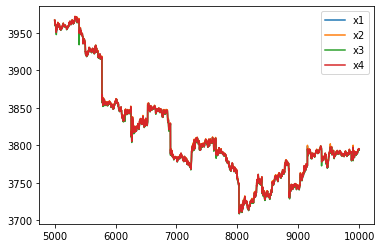

In [6]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [7]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled.shape)
df_for_training_scaled[-4:,::]

(10000, 4)


array([[-0.92958494, -0.93530112, -0.9222946 , -0.93041067],
       [-0.9300142 , -0.93530112, -0.92315269, -0.92769199],
       [-0.92729554, -0.93472861, -0.93874138, -0.93584803],
       [-0.93631004, -0.94145568, -0.92901633, -0.93398788]])

In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df[i + n_future - 1:i + n_future, 0])

In [9]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
#print(trainY)

trainX shape == (9986, 14, 4).
trainY shape == (9986, 1).


In [ ]:
print(trainX[-2:,::,::])

In [ ]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

In [10]:
# define the LSTM model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31,681
Trainable params: 31,681
Non-traina

Epoch 1/10
562/562 [==============================] - 19s 34ms/step - loss: 0.2511 - val_loss: 0.2512
Epoch 2/10
562/562 [==============================] - 19s 33ms/step - loss: 0.2509 - val_loss: 0.2498
Epoch 3/10
562/562 [==============================] - 18s 32ms/step - loss: 0.2507 - val_loss: 0.2495
Epoch 4/10
562/562 [==============================] - 13s 23ms/step - loss: 0.2507 - val_loss: 0.2497
Epoch 5/10
562/562 [==============================] - 15s 27ms/step - loss: 0.2506 - val_loss: 0.2497
Epoch 6/10
562/562 [==============================] - 15s 26ms/step - loss: 0.2507 - val_loss: 0.2507
Epoch 7/10
562/562 [==============================] - 10s 17ms/step - loss: 0.2509 - val_loss: 0.2499
Epoch 8/10
562/562 [==============================] - 14s 24ms/step - loss: 0.2505 - val_loss: 0.2508
Epoch 9/10
562/562 [==============================] - 11s 20ms/step - loss: 0.2505 - val_loss: 0.2517
Epoch 10/10
562/562 [==============================] - 13s 23ms/step - loss: 0.250

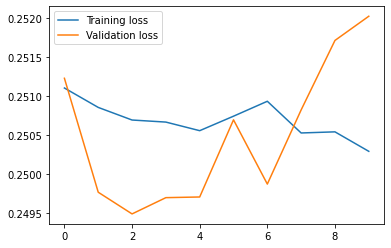

In [19]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [20]:
model.save('content/LSTM_model.h5')

In [21]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

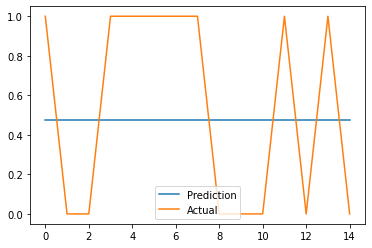

In [22]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
actual = trainY[-n_days_for_prediction:]

plt.plot(prediction, label='Prediction')
plt.plot(actual, label='Actual')
plt.legend()

In [23]:
print(prediction)
print(prediction.shape)
# print(type(prediction))

[[0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]
 [0.47278696]]
(15, 1)


In [24]:
pred = prediction
pred[pred > 0.5] = 1
pred[pred < 0.5] = 0
print(pred)
print(pred.shape)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(15, 1)


In [25]:
acc = actual-pred
acc = np.absolute(acc)
err = np.sum(acc)
accuracy = err/acc.shape[0]
print(accuracy)

0.5333333333333333


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


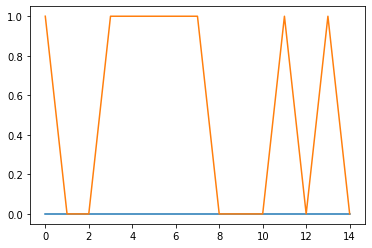

In [26]:
sns.lineplot(range(pred.shape[0]), np.reshape(pred,(15)))
sns.lineplot(range(pred.shape[0]), np.reshape(actual,(15)))

# Testing Code

In [49]:
#Read the csv file
df = pd.read_csv('/content/test_data_Analytics GC.xlsx - Sheet1.csv')
print(df.head())

        x1       x2       x3       x4
0  3798.66  3798.84  3798.09  3798.16
1  3798.22  3798.78  3798.13  3798.53
2  3798.50  3799.06  3798.28  3798.28
3  3798.31  3798.41  3797.53  3798.06
4  3797.94  3798.78  3797.84  3798.75


In [50]:
df.shape

(1000, 4)

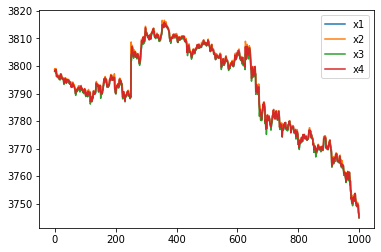

In [51]:
df_for_plot=df.tail(1000)
df_for_plot.plot.line()

In [52]:
#New dataframe with only training data - 5 columns
df_for_training = df.to_numpy(dtype=float)
print(type(df_for_training))
print(df_for_training.shape)

<class 'numpy.ndarray'>
(1000, 4)


In [53]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled.shape)
df_for_training_scaled[-4:,::]

(1000, 4)


array([[-2.58956388, -2.62428973, -2.59022261, -2.61715931],
       [-2.62505685, -2.65547048, -2.73877028, -2.7686894 ],
       [-2.76702876, -2.78642962, -2.77776404, -2.79974064],
       [-2.83303325, -2.83507159, -2.85141893, -2.88854721]])

In [54]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
testX = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    testX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])

In [55]:
testX = np.array(testX)

print('trainX shape == {}.'.format(testX.shape))

trainX shape == (986, 14, 4).


In [61]:
#Make prediction
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction
pred = prediction
pred[pred > 0.5] = 1
pred[pred < 0.5] = 0
pred.astype(int)
print(pred[:10])
print(pred.shape)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
(986, 1)


In [62]:
import csv

header = ['y']
with open('predictions.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    for i in range(1000):
      if i<14:
        writer.writerow('1')
      else:
        # write the data
        writer.writerow(pred[i-14])